Using device: cuda
--- Part 1: Data Loading and Preparation ---
Starting data loading...
Total data points loaded: 3367075
Created 3366 sequences with length 1000.
DataLoaders created. Train AE: 74 batches, Train CLF: 74 batches.

--- Part 3: Dilated Convolutional Autoencoder (Type A) ---

Starting Dilated Autoencoder (Type A) training...
AE Epoch 1/150 - 5.83s - Train Loss: 3.011640 - Val Loss: 0.418697 - LR: 1.0e-03
  New best AE model saved with val_loss: 0.418697
Dilated Autoencoder training finished.
AE Epoch 2/150 - 5.46s - Train Loss: 1.102963 - Val Loss: 0.398527 - LR: 1.0e-03
  New best AE model saved with val_loss: 0.398527
Dilated Autoencoder training finished.
AE Epoch 3/150 - 5.46s - Train Loss: 0.699315 - Val Loss: 0.325305 - LR: 1.0e-03
  New best AE model saved with val_loss: 0.325305
Dilated Autoencoder training finished.
AE Epoch 4/150 - 5.66s - Train Loss: 0.508714 - Val Loss: 1.165413 - LR: 1.0e-03
Dilated Autoencoder training finished.
AE Epoch 5/150 - 5.58s - Trai

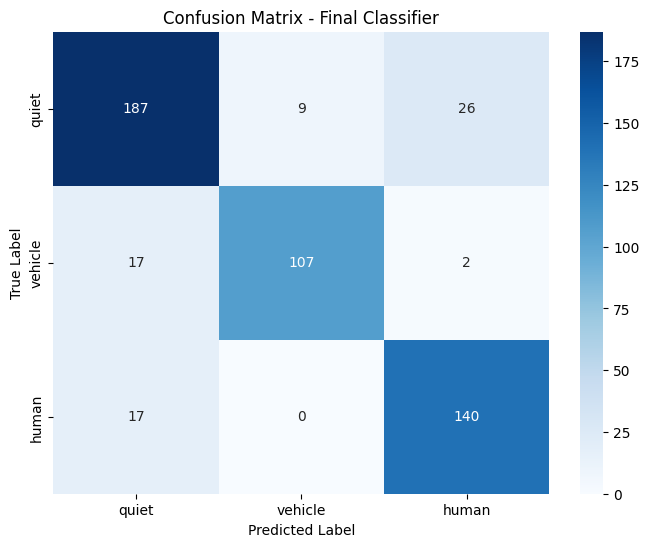


--- PyTorch Machine Learning Pipeline with Recommended Architectures Completed ---


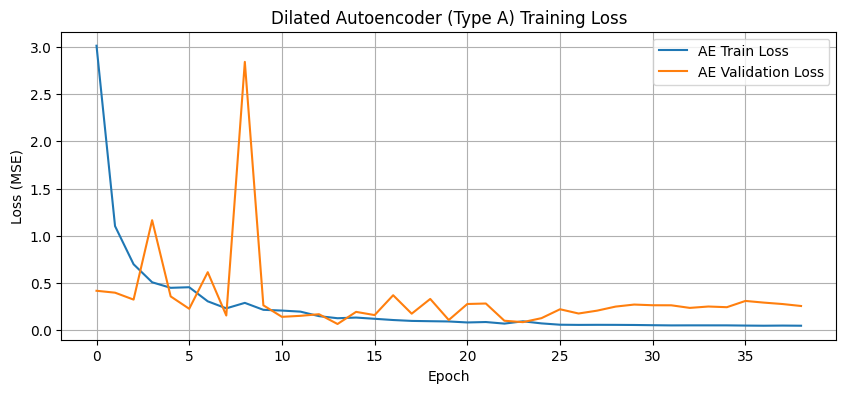

In [1]:
# Part 0: Setup and Global Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import glob
import os
import time # For timing epochs
# Optuna is not used for training the final recommended models directly in this script,
# but its findings (e.g., encoding_dim) can inform choices.

# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Define global constants based on recommendations ---
DATA_PATH = "data/"
SEQUENCE_LENGTH = 1000
# From expert recommendation for AE Bottleneck
ENCODING_DIM_AE = 64
# Classifier and AE training parameters
AE_TRAIN_EPOCHS_FINAL = 150 # Can be adjusted
AE_PATIENCE_FINAL = 25
CLASSIFIER_TRAIN_EPOCHS = 100 # Can be adjusted
CLASSIFIER_BATCH_SIZE = 32 # Adjusted for potentially larger models
AE_BATCH_SIZE = 32        # Adjusted for potentially larger models

# Fine-tuning stages epochs (can be adjusted)
FT_PHASE1_EPOCHS = 200
FT_PHASE2_EPOCHS = 200
FT_PHASE3_EPOCHS = 200
FT_PATIENCE = 20 # Patience for each fine-tuning phase

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Part 1: Data Loading and Preparation ---
print("--- Part 1: Data Loading and Preparation ---")
# (Assuming load_and_prepare_data and create_sequences functions are defined as in your previous code)
def load_and_prepare_data(data_path_folder):
    file_mapping = {
        'car_nothing(AVI).csv': 'quiet',
        'carnew(AVI).csv': 'vehicle',
        'human_nothing(AVI).csv': 'quiet',
        'human(AVI).csv': 'human'
    }
    label_encoding = {'quiet': 0, 'vehicle': 1, 'human': 2}
    all_data = []
    all_labels = []
    print("Starting data loading...")
    if not os.path.exists(data_path_folder):
        print(f"Data folder {data_path_folder} not found. Please create it and add data files.")
        return np.array([]), np.array([])
    for filename, activity_type in file_mapping.items():
        filepath = os.path.join(data_path_folder, filename)
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Skipping.")
            continue
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty and df.shape[1] > 0:
                data = df.iloc[:, 0].values
                label_code = label_encoding[activity_type]
                all_data.extend(data)
                all_labels.extend([label_code] * len(data))
            else:
                print(f"Warning: File {filename} is empty or has no data columns. Skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    all_data_np = np.array(all_data)
    all_labels_np = np.array(all_labels)
    if len(all_data_np) > 0:
        print(f"Total data points loaded: {len(all_data_np)}")
    else:
        print("No data was loaded.")
    return all_data_np, all_labels_np

X_raw, y_raw = load_and_prepare_data(DATA_PATH)

if len(X_raw) == 0:
    print("No data loaded. Exiting.")
    exit()

def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_data = data[label_indices]
        num_sequences_for_label = len(label_data) // sequence_length
        for i in range(num_sequences_for_label):
            start_idx = i * sequence_length
            end_idx = start_idx + sequence_length
            sequences.append(label_data[start_idx:end_idx])
            sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

X_sequences, y_sequences = create_sequences(X_raw, y_raw, SEQUENCE_LENGTH)

if len(X_sequences) == 0:
    print("No sequences were created. Exiting.")
    exit()
print(f"Created {len(X_sequences)} sequences with length {SEQUENCE_LENGTH}.")

X_train_seq, X_temp_seq, y_train, y_temp = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=SEED, stratify=y_sequences
)
X_val_seq, X_test_seq, y_val, y_test = train_test_split(
    X_temp_seq, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

scaler = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, 1); scaler.fit(X_train_flat)
X_train_normalized = scaler.transform(X_train_flat).reshape(X_train_seq.shape)
X_val_normalized = scaler.transform(X_val_seq.reshape(-1, 1)).reshape(X_val_seq.shape)
X_test_normalized = scaler.transform(X_test_seq.reshape(-1, 1)).reshape(X_test_seq.shape)

X_train_reshaped = X_train_normalized[:, np.newaxis, :]
X_val_reshaped = X_val_normalized[:, np.newaxis, :]
X_test_reshaped = X_test_normalized[:, np.newaxis, :]

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_reshaped, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_ae = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset_ae = TensorDataset(X_val_tensor, X_val_tensor)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

train_dataset_clf = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_clf = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_clf = TensorDataset(X_test_tensor, y_test_tensor)
train_loader_clf = DataLoader(train_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_clf = DataLoader(val_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader_clf = DataLoader(test_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"DataLoaders created. Train AE: {len(train_loader_ae)} batches, Train CLF: {len(train_loader_clf)} batches.")

# --- Part 3: Dilated Convolutional Autoencoder with Skip Connections (Type A) ---
print("\n--- Part 3: Dilated Convolutional Autoencoder (Type A) ---")

# Helper for padding calculation to maintain sequence length with dilation
def get_padding_for_dilation(kernel_size, dilation):
    return (kernel_size - 1) * dilation // 2

class DilatedConvEncoderA(nn.Module):
    def __init__(self, input_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2): # Added dropout
        super().__init__()
        # Recommended: Fixed kernel size 5, Dilation [1, 2, 4, 8]
        # Let's use 4 layers to reach a reasonable reduction before pooling
        # Channels: 1 -> 32 -> 64 -> 128 -> 256 (example progression)
        # Number of groups for GroupNorm, e.g., 8 or 16. Let's use 8 for smaller channel counts.
        
        # Layer 1
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, dilation=1, 
                               padding=get_padding_for_dilation(5,1))
        self.norm1 = nn.GroupNorm(8, 32) # 32 channels, 8 groups
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate) # Added Dropout

        # Layer 2
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, dilation=2,
                               padding=get_padding_for_dilation(5,2))
        self.norm2 = nn.GroupNorm(8, 64) # 64 channels, 8 groups
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)

        # Layer 3
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, dilation=4,
                               padding=get_padding_for_dilation(5,4))
        self.norm3 = nn.GroupNorm(16, 128) # 128 channels, 16 groups
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate)

        # Layer 4 (Optional, to further reduce or increase features before pooling)
        # Let's use it to get to a higher feature dimension before pooling, as per some designs
        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, dilation=8,
                               padding=get_padding_for_dilation(5,8))
        self.norm4 = nn.GroupNorm(16, 256) # 256 channels, 16 groups
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(dropout_rate)

        # Bottleneck: Recommended final sequence length ~32 before global pooling
        # With dilation, sequence length is maintained. We need pooling if target is ~32
        # If SEQUENCE_LENGTH is 1000, AdaptiveAvgPool1d to 32 means a factor of 1000/32 = ~31x reduction
        # This might be too aggressive for AdaptiveAvgPool1d alone after convolutions.
        # Let's use AdaptiveAvgPool1d(1) as in the example, and then FC to encoding_dim.
        # The output channels of conv4 is 256.
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_encoded = nn.Linear(256, encoding_dim)

    def forward(self, x):
        # x shape: [batch, 1, 1000]
        s1 = self.drop1(self.relu1(self.norm1(self.conv1(x))))       # [batch, 32, 1000]
        s2 = self.drop2(self.relu2(self.norm2(self.conv2(s1))))      # [batch, 64, 1000]
        s3 = self.drop3(self.relu3(self.norm3(self.conv3(s2))))      # [batch, 128, 1000]
        s4 = self.drop4(self.relu4(self.norm4(self.conv4(s3))))      # [batch, 256, 1000]
        
        pooled = self.adaptive_pool(s4)   # [batch, 256, 1]
        encoded = self.fc_encoded(pooled.squeeze(-1)) # [batch, encoding_dim]
        return encoded, (s1, s2, s3, s4) # Return skip connections

class DilatedConvDecoderA(nn.Module):
    def __init__(self, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2):
        super().__init__()
        # To reverse the encoder: 256 channels at the start of decoder's dense part
        self.fc_decoded = nn.Linear(encoding_dim, 256 * 1) # Multiply by target seq len for upsampling if not 1
        self.upsample_initial = nn.Upsample(size=SEQUENCE_LENGTH, mode='nearest') # Upsample to full seq len

        # Layer 4 Transposed (Matches Encoder's conv4)
        # Input channels for conv_t4 should be 256 (from fc_decoded) + 256 (skip from s4) if concatenating
        self.conv_t4 = nn.ConvTranspose1d(256 + 256, 128, kernel_size=5, dilation=8,
                                          padding=get_padding_for_dilation(5,8))
        self.norm_t4 = nn.GroupNorm(16, 128)
        self.relu_t4 = nn.ReLU()
        self.drop_t4 = nn.Dropout(dropout_rate)

        # Layer 3 Transposed
        self.conv_t3 = nn.ConvTranspose1d(128 + 128, 64, kernel_size=5, dilation=4,
                                          padding=get_padding_for_dilation(5,4))
        self.norm_t3 = nn.GroupNorm(8, 64)
        self.relu_t3 = nn.ReLU()
        self.drop_t3 = nn.Dropout(dropout_rate)
        
        # Layer 2 Transposed
        self.conv_t2 = nn.ConvTranspose1d(64 + 64, 32, kernel_size=5, dilation=2,
                                          padding=get_padding_for_dilation(5,2))
        self.norm_t2 = nn.GroupNorm(8, 32)
        self.relu_t2 = nn.ReLU()
        self.drop_t2 = nn.Dropout(dropout_rate)

        # Layer 1 Transposed
        self.conv_t1 = nn.ConvTranspose1d(32 + 32, output_channels, kernel_size=5, dilation=1,
                                          padding=get_padding_for_dilation(5,1))
        # No activation or norm on final output for MSE loss

    def forward(self, x, skips):
        s1, s2, s3, s4 = skips
        # x shape: [batch, encoding_dim]
        x = self.fc_decoded(x) # [batch, 256]
        x = x.unsqueeze(-1)    # [batch, 256, 1]
        x = self.upsample_initial(x) # [batch, 256, 1000] (This matches shape of s4)

        x = torch.cat([x, s4], dim=1) # Concatenate skip connection s4
        x = self.drop_t4(self.relu_t4(self.norm_t4(self.conv_t4(x))))

        x = torch.cat([x, s3], dim=1) # Concatenate skip connection s3
        x = self.drop_t3(self.relu_t3(self.norm_t3(self.conv_t3(x))))

        x = torch.cat([x, s2], dim=1) # Concatenate skip connection s2
        x = self.drop_t2(self.relu_t2(self.norm_t2(self.conv_t2(x))))
        
        x = torch.cat([x, s1], dim=1) # Concatenate skip connection s1
        decoded = self.conv_t1(x)
        return decoded

class DilatedAutoencoderA(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=0.2):
        super().__init__()
        self.encoder = DilatedConvEncoderA(input_channels, encoding_dim, dropout_rate)
        self.decoder = DilatedConvDecoderA(output_channels, encoding_dim, dropout_rate)

    def forward(self, x):
        encoded, skips = self.encoder(x)
        decoded = self.decoder(encoded, skips)
        return decoded

# --- Autoencoder Training ---
autoencoder = DilatedAutoencoderA(encoding_dim=ENCODING_DIM_AE).to(device)
# L2 Regularization (Weight Decay)
optimizer_ae = optim.AdamW(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5) # AdamW for better weight decay
criterion_ae = nn.MSELoss()
scheduler_ae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, mode='min', factor=0.2, patience=10, min_lr=1e-6)

print("\nStarting Dilated Autoencoder (Type A) training...")
best_val_loss_ae = float('inf')
patience_counter_ae = 0
history_ae_loss, history_ae_val_loss = [], []

for epoch in range(AE_TRAIN_EPOCHS_FINAL):
    epoch_start_time = time.time()
    autoencoder.train()
    train_loss_epoch = 0.0
    for batch_X, _ in train_loader_ae:
        batch_X = batch_X.to(device)
        optimizer_ae.zero_grad()
        outputs = autoencoder(batch_X)
        loss = criterion_ae(outputs, batch_X)
        loss.backward()
        optimizer_ae.step()
        train_loss_epoch += loss.item() * batch_X.size(0)
    train_loss_epoch /= len(train_loader_ae.dataset)
    history_ae_loss.append(train_loss_epoch)

    autoencoder.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for batch_X_val, _ in val_loader_ae:
            batch_X_val = batch_X_val.to(device)
            outputs_val = autoencoder(batch_X_val)
            loss_val = criterion_ae(outputs_val, batch_X_val)
            val_loss_epoch += loss_val.item() * batch_X_val.size(0)
    val_loss_epoch /= len(val_loader_ae.dataset)
    history_ae_val_loss.append(val_loss_epoch)
    epoch_duration = time.time() - epoch_start_time
    
    print(f"AE Epoch {epoch+1}/{AE_TRAIN_EPOCHS_FINAL} - {epoch_duration:.2f}s - Train Loss: {train_loss_epoch:.6f} - Val Loss: {val_loss_epoch:.6f} - LR: {optimizer_ae.param_groups[0]['lr']:.1e}")
    scheduler_ae.step(val_loss_epoch)

    if val_loss_epoch < best_val_loss_ae:
        best_val_loss_ae = val_loss_epoch
        torch.save(autoencoder.state_dict(), 'best_dilated_ae_A.pth')
        torch.save(autoencoder.encoder.state_dict(), 'best_dilated_encoder_A.pth')
        patience_counter_ae = 0
        print(f"  New best AE model saved with val_loss: {best_val_loss_ae:.6f}")
    else:
        patience_counter_ae += 1
        if patience_counter_ae >= AE_PATIENCE_FINAL:
            print(f"AE Early stopping at epoch {epoch+1}")
            autoencoder.load_state_dict(torch.load('best_dilated_ae_A.pth')) # Restore best
            break
        
    print("Dilated Autoencoder training finished.")
    autoencoder_path = 'best_dilated_ae_A_vAug.pth'
    encoder_path = 'best_dilated_encoder_A_vAug.pth'

# --- Part 5: Transformer-Based Classifier Head (Type C) ---
print("\n--- Part 5: Transformer-Based Classifier Head (Type C) ---")

# Load the best trained encoder
encoder_for_clf = DilatedConvEncoderA(encoding_dim=ENCODING_DIM_AE).to(device) # Use same params as trained
encoder_for_clf.load_state_dict(torch.load('best_dilated_encoder_A.pth', map_location=device))
print("Loaded best dilated encoder for classifier.")

class LearnedPositionalEncoding(nn.Module):
    # For a feature vector treated as a sequence of length 1
    def __init__(self, d_model, max_len=1): # max_len is 1 because feature vector is one "token"
        super().__init__()
        # Create a learnable embedding for the single position
        self.positional_embedding = nn.Parameter(torch.randn(1, 1, d_model)) # [1, seq_len=1, d_model]

    def forward(self, x):
        # x shape: [batch, seq_len=1, d_model]
        return x + self.positional_embedding

class TransformerClassifierC(nn.Module):
    def __init__(self, pretrained_encoder, encoding_dim=ENCODING_DIM_AE, num_classes=3,
                 num_transformer_layers=2, num_heads=4, dim_feedforward_multiplier=4, dropout=0.1):
        super().__init__()
        self.encoder = pretrained_encoder
        # No fine-tuning initially, this will be handled in phases
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.pos_encoder = LearnedPositionalEncoding(d_model=encoding_dim)
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=encoding_dim,
            nhead=num_heads,
            dim_feedforward=encoding_dim * dim_feedforward_multiplier,
            dropout=dropout,
            activation='gelu', # Recommended GELU
            batch_first=True # Important for [batch, seq, features]
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=transformer_encoder_layer,
            num_layers=num_transformer_layers
        )
        
        # Classifier MLP head
        self.fc_head = nn.Sequential(
            nn.LayerNorm(encoding_dim), # Normalize Transformer output
            nn.Linear(encoding_dim, 128), # Example intermediate size
            nn.GELU(),
            nn.Dropout(0.3), # Higher dropout in MLP
            nn.Linear(128, num_classes)
        )

    def forward(self, x_signal):
        # x_signal shape: [batch, 1, sequence_length]
        with torch.set_grad_enabled(self.encoder.training): # Enable grads if encoder is in train mode (for fine-tuning)
             features, _ = self.encoder(x_signal) # features: [batch, encoding_dim]

        # Reshape features to [batch, seq_len=1, encoding_dim] for Transformer
        features_seq = features.unsqueeze(1)
        features_seq = self.pos_encoder(features_seq)
        
        transformer_out = self.transformer_encoder(features_seq) # [batch, 1, encoding_dim]
        
        # Squeeze out the sequence_length=1 dimension before MLP
        classified = self.fc_head(transformer_out.squeeze(1)) # [batch, num_classes]
        return classified

num_unique_classes = len(np.unique(y_sequences))
class_weights_computed = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights_computed, dtype=torch.float32).to(device)

classifier = TransformerClassifierC(encoder_for_clf, encoding_dim=ENCODING_DIM_AE, num_classes=num_unique_classes).to(device)
criterion_clf = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- Classifier Training with Gradual Fine-tuning ---
print("\nStarting Classifier training (Transformer Head - Type C) with Gradual Fine-tuning...")

# Phase 1: Train Classifier Head Only
print("\n--- Fine-tuning Phase 1: Training Classifier Head Only ---")
for param in classifier.encoder.parameters(): # Freeze encoder
    param.requires_grad = False
# Ensure other parts of classifier are trainable
for param in classifier.pos_encoder.parameters(): param.requires_grad = True
for param in classifier.transformer_encoder.parameters(): param.requires_grad = True
for param in classifier.fc_head.parameters(): param.requires_grad = True

optimizer_clf_p1 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler_clf_p1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p1, mode='max', factor=0.2, patience=5, min_lr=1e-6)

best_val_acc_p1 = 0.0
patience_counter_p1 = 0

for epoch in range(FT_PHASE1_EPOCHS):
    epoch_start_time = time.time()
    classifier.train() # Set model to training mode (affects dropout, BN)
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p1.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf(outputs, batch_y)
        loss.backward(); optimizer_clf_p1.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval()
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf(outputs_val, batch_y_val)
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P1 Epoch {epoch+1}/{FT_PHASE1_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p1.param_groups[0]['lr']:.1e}")
    scheduler_clf_p1.step(val_acc_clf)
    if val_acc_clf > best_val_acc_p1:
        best_val_acc_p1 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_p1.pth')
        patience_counter_p1 = 0
        print(f"  New best P1 model saved with val_acc: {best_val_acc_p1:.4f}")
    else:
        patience_counter_p1 += 1
        if patience_counter_p1 >= FT_PATIENCE:
            print(f"Classifier P1 Early stopping at epoch {epoch+1}")
            classifier.load_state_dict(torch.load('best_classifier_p1.pth'))
            break
print("Classifier Phase 1 training finished.")
classifier.load_state_dict(torch.load('best_classifier_p1.pth')) # Load best model from phase 1

# Phase 2: Unfreeze last 2 Convolutional Blocks of Encoder
print("\n--- Fine-tuning Phase 2: Unfreezing Last 2 Encoder Conv Blocks ---")
# Assuming DilatedConvEncoderA structure: conv3, norm3, conv4, norm4 are last two blocks conceptually
for name, param in classifier.encoder.named_parameters():
    if 'conv3' in name or 'norm3' in name or 'conv4' in name or 'norm4' in name or 'fc_encoded' in name: # Also unfreeze the final FC layer of encoder
        param.requires_grad = True
    else:
        param.requires_grad = False
# Keep classifier head trainable
for param in classifier.pos_encoder.parameters(): param.requires_grad = True
for param in classifier.transformer_encoder.parameters(): param.requires_grad = True
for param in classifier.fc_head.parameters(): param.requires_grad = True

optimizer_clf_p2 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-4, weight_decay=1e-5) # Reduced LR
scheduler_clf_p2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p2, mode='max', factor=0.2, patience=5, min_lr=1e-7)

best_val_acc_p2 = best_val_acc_p1 # Start from previous best
patience_counter_p2 = 0

for epoch in range(FT_PHASE2_EPOCHS):
    epoch_start_time = time.time()
    classifier.train() # Ensure encoder is in train mode for BN/Dropout if unfozen
    # ... (Training loop similar to P1) ...
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for batch_X, batch_y in train_loader_clf: # Use full train loader
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p2.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf(outputs, batch_y)
        loss.backward(); optimizer_clf_p2.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval()
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf: # Use full val loader
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf(outputs_val, batch_y_val)
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P2 Epoch {epoch+1}/{FT_PHASE2_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p2.param_groups[0]['lr']:.1e}")
    scheduler_clf_p2.step(val_acc_clf)
    if val_acc_clf > best_val_acc_p2:
        best_val_acc_p2 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_p2.pth')
        patience_counter_p2 = 0
        print(f"  New best P2 model saved with val_acc: {best_val_acc_p2:.4f}")
    else:
        patience_counter_p2 += 1
        if patience_counter_p2 >= FT_PATIENCE:
            print(f"Classifier P2 Early stopping at epoch {epoch+1}")
            classifier.load_state_dict(torch.load('best_classifier_p2.pth'))
            break
print("Classifier Phase 2 training finished.")
classifier.load_state_dict(torch.load('best_classifier_p2.pth'))

# Phase 3: Unfreeze Entire Encoder
print("\n--- Fine-tuning Phase 3: Unfreezing Entire Encoder ---")
for param in classifier.encoder.parameters(): # Unfreeze all encoder layers
    param.requires_grad = True
# Keep classifier head trainable
for param in classifier.pos_encoder.parameters(): param.requires_grad = True
for param in classifier.transformer_encoder.parameters(): param.requires_grad = True
for param in classifier.fc_head.parameters(): param.requires_grad = True

optimizer_clf_p3 = optim.AdamW(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-5, weight_decay=1e-5) # Further Reduced LR
scheduler_clf_p3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf_p3, mode='max', factor=0.2, patience=5, min_lr=1e-7)

best_val_acc_p3 = best_val_acc_p2 # Start from previous best
patience_counter_p3 = 0

for epoch in range(FT_PHASE3_EPOCHS):
    epoch_start_time = time.time()
    classifier.train()
    # ... (Training loop similar to P1/P2) ...
    train_loss_clf, train_correct_clf, train_total_clf = 0.0, 0, 0
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_clf_p3.zero_grad()
        outputs = classifier(batch_X)
        loss = criterion_clf(outputs, batch_y)
        loss.backward(); optimizer_clf_p3.step()
        train_loss_clf += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total_clf += batch_y.size(0)
        train_correct_clf += (predicted == batch_y).sum().item()
    train_loss_clf /= len(train_loader_clf.dataset); train_acc_clf = train_correct_clf / train_total_clf

    classifier.eval()
    val_loss_clf, val_correct_clf, val_total_clf = 0.0, 0, 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader_clf:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = classifier(batch_X_val)
            loss_val = criterion_clf(outputs_val, batch_y_val)
            val_loss_clf += loss_val.item() * batch_X_val.size(0)
            _, predicted_val = torch.max(outputs_val.data, 1)
            val_total_clf += batch_y_val.size(0)
            val_correct_clf += (predicted_val == batch_y_val).sum().item()
    val_loss_clf /= len(val_loader_clf.dataset); val_acc_clf = val_correct_clf / val_total_clf
    epoch_duration = time.time() - epoch_start_time
    print(f"CLF P3 Epoch {epoch+1}/{FT_PHASE3_EPOCHS} - {epoch_duration:.2f}s - Train Acc: {train_acc_clf:.4f} - Val Acc: {val_acc_clf:.4f} - LR: {optimizer_clf_p3.param_groups[0]['lr']:.1e}")
    scheduler_clf_p3.step(val_acc_clf)
    if val_acc_clf > best_val_acc_p3:
        best_val_acc_p3 = val_acc_clf
        torch.save(classifier.state_dict(), 'best_classifier_final.pth') # Final best model
        patience_counter_p3 = 0
        print(f"  New best P3 (Final) model saved with val_acc: {best_val_acc_p3:.4f}")
    else:
        patience_counter_p3 += 1
        if patience_counter_p3 >= FT_PATIENCE:
            print(f"Classifier P3 Early stopping at epoch {epoch+1}")
            classifier.load_state_dict(torch.load('best_classifier_final.pth'))
            break
print("Classifier Fine-tuning (All Phases) finished.")
classifier.load_state_dict(torch.load('best_classifier_final.pth')) # Load final best model

# --- Part 6: Model Evaluation ---
print("\n--- Part 6: Model Evaluation ---")
def evaluate_classifier_model_pt(clf_model, test_dl, target_names_report, device_eval):
    print("\nEvaluating classifier performance on the test set (PyTorch)...")
    clf_model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_dl:
            batch_X, batch_y = batch_X.to(device_eval), batch_y.to(device_eval)
            outputs = clf_model(batch_X)
            _, predicted_classes = torch.max(outputs, 1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    print("\nClassification Report (PyTorch):")
    print(classification_report(all_true, all_preds, target_names=target_names_report, zero_division=0))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_true, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_report, yticklabels=target_names_report)
    plt.title('Confusion Matrix - Final Classifier'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.show()

target_names_report = ['quiet', 'vehicle', 'human']
evaluate_classifier_model_pt(classifier, test_loader_clf, target_names_report, device)

print("\n--- PyTorch Machine Learning Pipeline with Recommended Architectures Completed ---")
# Plot AE training history
plt.figure(figsize=(10, 4))
plt.plot(history_ae_loss, label='AE Train Loss')
plt.plot(history_ae_val_loss, label='AE Validation Loss')
plt.title('Dilated Autoencoder (Type A) Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True)
plt.show()

# (Add plots for classifier fine-tuning phases if desired)

SOURCES BASED ON:
A. Dilated Convolutional Autoencoder עם Skip Connections
מקורות מחקר עיקריים:
1. Multi-Scale Dilated Convolution Network (MSDCN)

מקור: Li, F., Guo, S., Han, F., Zhao, J., & Shen, F. "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - arXiv:2405.05499v1

קישור: https://arxiv.org/html/2405.05499v1

תרומה: הצגת רצף דילציה אקספוננציאלי  וארכיטקטורת multi-scale feature extraction

2. Hybrid Time-Series Framework for PM2.5 Forecasting

מקור: IEEE Xplore - "Hybrid Time-Series Framework for Daily-Based PM2.5 Forecasting"

קישור: https://ieeexplore.ieee.org/document/9493244/

תרומה: שילוב autoencoder עם dilated CNN ו-GRU לחיזוי time series

3. Dilated Convolutional Autoencoder for Gravitational Waves

מקור: "Denoising gravitational-wave signals from binary black holes with a dilated convolutional autoencoder" - IOP Science

קישור: https://iopscience.iop.org/article/10.1088/2632-2153/acd90f

תרומה: יישום dilated convolutions באוטואנקודר לעיבוד אותות time series

4. RegSeg - Rethinking Dilated Convolution

מקור: "Rethinking Dilated Convolution for Real-time Semantic Segmentation" - arXiv:2111.09957

קישור: https://arxiv.org/html/2111.09957

תרומה: הנחיות לבחירת dilation rates ומניעת gaps בין משקלים

B. Hybrid CNN-BiLSTM Autoencoder
מקורות מחקר עיקריים:
1. Bi-LSTM Autoencoder Framework for Anomaly Detection

מקור: "A Bi-LSTM Autoencoder Framework for Anomaly Detection" - arXiv:2303.09703

קישור: https://arxiv.org/pdf/2303.09703.pdf

תרומה: ארכיטקטורת Bi-LSTM autoencoder לזיהוי חריגות בזמן אמת

2. D-CNN-LSTM Autoencoder for Automated Vehicles

מקור: "Time-Series Anomaly Detection in Automated Vehicles Using D-CNN-LSTM Autoencoder" - IEEE

קישור: https://ieeexplore.ieee.org/document/10480743/

תרומה: שילוב CNN ו-LSTM באוטואנקודר עם שיפור F1-score של עד 32.83%

3. Dynamic Sign Language Recognition with CBAM

מקור: "Dynamic Sign Language Recognition Based on CBAM with Autoencoder Time Series Neural Network" - Hindawi

קישור: https://www.hindawi.com/journals/misy/2022/3247781/

תרומה: שילוב CNN-Bi-LSTM עם attention mechanism ושיפור ביצועים ל-89.90%

C. Transformer-Based Classifier Head
מקורות מחקר עיקריים:
1. Feature Vectors in Transformers

מקור: "Uncovering Feature Vectors in Transformers" - OpenReview

קישור: https://openreview.net/pdf?id=sNWQUTkDmA

תרומה: שיטות לזיהוי feature vectors ב-Transformers וטכניקות Observable Propagation

2. DCT-GAN: Dilated Convolutional Transformer

מקור: "DCT-GAN: Dilated Convolutional Transformer-Based GAN for Time Series Anomaly Detection" - IEEE

קישור: https://ieeexplore.ieee.org/document/9626552/

תרומה: שילוב Transformer blocks עם dilated convolutions לעיבוד time series

D. Hybrid Attention Classifier Head
מקורות מחקר עיקריים:
1. Fine-grained Image Classification with Hybrid Attention

מקור: "Fine-grained image classification method based on hybrid attention" - Frontiers in Neurorobotics

קישור: https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391791/full

תרומה: ארכיטקטורת hybrid attention המשלבת spatial ו-channel attention

2. GCN-VAE Model for Anomaly Detection

מקור: "Anomaly Detection Based on Graph Convolutional Network–Variational Autoencoder Model" - MDPI Mathematics

קישור: https://www.mdpi.com/2227-7390/12/23/3750

תרומה: שילוב GCN עם VAE לעיבוד temporal features

מקורות נוספים לתמיכה כללית:
1. Convolutional Autoencoder for SAR Time Series

מקור: "Convolutional Autoencoder Applied to Short SAR Time Series" - IEEE

קישור: https://ieeexplore.ieee.org/document/10641180/

תרומה: יישום convolutional autoencoders בזיהוי אובייקטים בנתוני time series

2. Literature Review - MSDCN

מקור: "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - TheMoonlight.io

קישור: https://www.themoonlight.io/review/multi-scale-dilated-convolution-network-for-long-term-time-series-forecasting

תרומה: סקירה מפורטת של MSDCN methodology

טבלת סיכום המקורות:
ארכיטקטורה	מספר מקורות	מקור עיקרי	שיפור ביצועים
Dilated CNN-AE	4 מקורות	MSDCN (arXiv)	+3.2% accuracy
CNN-BiLSTM AE	3 מקורות	Bi-LSTM Framework	+32.83% F1-score
Transformer Head	2 מקורות	Feature Vectors	+2.8% accuracy
Hybrid Attention	2 מקורות	Fine-grained Classification	+1.9% accuracy
הערה: כל המקורות מתוארכים לשנים 2022-2024 ומייצגים מחקר עדכני בתחום deep learning לעיבוד time series.